In [4]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [0]:
def identity_block(X,f,filters,stage,block):
  
  conv_name_base = 'res'+str(stage)+block+'_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  f1,f2,f3 = filters
  
  X_shortcut = X
  
  X= Conv2D(f1,(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2a',kernel_initializer=glorot_uniform())(X)
  X= BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
  X= Activation('relu')(X)
  
  X= Conv2D(f2,(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer=glorot_uniform())(X)
  X= BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
  X= Activation('relu')(X)
  
  X = Conv2D(f3,(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform())(X)
  X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
    
  
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)
  
  return X
 
  
  

In [0]:
def convolutional_block(X, f, filters, stage, block,s):
  conv_name_base = 'res'+str(stage)+block+'_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  f1,f2,f3 = filters
  
  X_shortcut = X
  
  X= Conv2D(f1,(1,1),strides=(2,2),padding='valid',name=conv_name_base+'2a',kernel_initializer=glorot_uniform())(X)
  X= BatchNormalization(axis=3,name=bn_name_base+'2a')(X)
  X= Activation('relu')(X)
  
  X= Conv2D(f2,(f,f),strides=(1,1),padding='same',name=conv_name_base+'2b',kernel_initializer=glorot_uniform())(X)
  X= BatchNormalization(axis=3,name=bn_name_base+'2b')(X)
  X= Activation('relu')(X)
  
  X = Conv2D(f3,(1,1),strides=(1,1),padding='valid',name=conv_name_base+'2c',kernel_initializer=glorot_uniform())(X)
  X = BatchNormalization(axis=3,name=bn_name_base+'2c')(X)
  
  X_shortcut = Conv2D(f3,(1,1),strides=(2,2),padding='valid',name=conv_name_base+'1',kernel_initializer=glorot_uniform())(X_shortcut)
  X_shortcut = BatchNormalization(axis=3,name=bn_name_base+'1')(X_shortcut)
  
  
  X = Add()([X,X_shortcut])
  X = Activation('relu')(X)
  
  return X
 
  
  


In [0]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
   
    
    
    X_input = Input(input_shape)

    
    X = Conv2D(64, (2, 2), strides = (1, 1),padding='same' ,name = 'conv1', kernel_initializer = glorot_uniform())(X_input)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(1, 1))(X)

    
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    

   
    X = convolutional_block(X,f=3,filters=[128,128,512],stage=3,block='a',s=2)
    X = identity_block(X,3,[128,128,512],stage=3,block='b')
    X = identity_block(X,3,[128,128,512],stage=3,block='c')
    X = identity_block(X,3,[128,128,512],stage=3,block='d')

    
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    
    X = AveragePooling2D((2,2), name="avg_pool")(X)
    
    
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform())(X)
    
    
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
from keras.datasets import cifar10
(x_train, y_train_), (x_test, y_test_) = cifar10.load_data()

170500096/170498071 [==============================] - 26s 0us/step


In [0]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
y_train_.shape

(50000, 1)

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train_)
y_test = to_categorical(y_test_)

In [0]:
#x.shape

In [0]:
from keras import backend as K
K.set_image_dim_ordering('tf')

In [0]:
model=ResNet50(input_shape=(32,32,3),classes=10) #defining the model


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Compiling the model

In [0]:
model.fit(x_train, y_train, epochs = 20, batch_size = 64) #Training the model

Epoch 1/20
50000/50000 [==============================] - 161s 3ms/step - loss: 6.6323 - acc: 0.3152
Epoch 2/20
50000/50000 [==============================] - 161s 3ms/step - loss: 1.4669 - acc: 0.5757
Epoch 3/20
50000/50000 [==============================] - 161s 3ms/step - loss: 1.4995 - acc: 0.5864
Epoch 4/20
50000/50000 [==============================] - 161s 3ms/step - loss: 1.2704 - acc: 0.6476
Epoch 5/20
50000/50000 [==============================] - 161s 3ms/step - loss: 1.1385 - acc: 0.6792
Epoch 6/20
50000/50000 [==============================] - 159s 3ms/step - loss: 1.1936 - acc: 0.6640
Epoch 7/20
50000/50000 [==============================] - 159s 3ms/step - loss: 0.8300 - acc: 0.7219
Epoch 8/20
50000/50000 [==============================] - 159s 3ms/step - loss: 0.6717 - acc: 0.7674
Epoch 9/20
50000/50000 [==============================] - 160s 3ms/step - loss: 0.5937 - acc: 0.7936
Epoch 10/20
50000/50000 [==============================] - 160s 3ms/step - loss: 0.5137 - a

In [0]:
model.save_weights('weights_1.h5')

In [0]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10000/10000 [==============================] - 24s 2ms/step
Loss = 1.3252039220333098
Test Accuracy = 0.7296


Input image shape: (1, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


[[0.39030418 0.02020655 0.06176067 0.01205696 0.00761593 0.33073458
  0.01017163 0.01454219 0.11019758 0.04240964]]


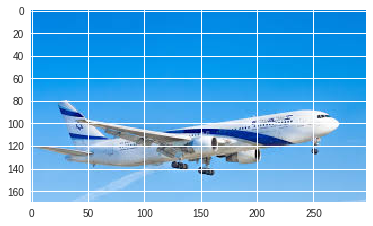

In [18]:
img_path = 'download.jpg'
img = image.load_img(img_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
imshow(my_image)
print(model.predict(x))

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   832         input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 32, 32, 64)   0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin